<a href="https://colab.research.google.com/github/lorischl-otter/DS-Unit-2-Kaggle-Challenge/blob/master/module1/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [X] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [X] Do train/validate/test split with the Tanzania Waterpumps data.
- [X] Begin with baselines for classification.
- [X] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [X] Get your validation accuracy score.
- [X] Get and plot your feature importances.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [X] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [X] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*


# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_full = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train / val dataframes
train, val = train_test_split(train_full, train_size=0.80, test_size=0.20, 
                              stratify=train_full['status_group'], 
                              random_state=7)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [9]:
# Pandas Profiling can be very slow with medium & large datasets.
# These parameters will make it faster.
# https://github.com/pandas-profiling/pandas-profiling/issues/222

import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [12]:
# Find baselines of training data
train['status_group'].value_counts(normalize=True)

# The non functional group is the majority class, with 54% frequency

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [5]:
# Look at data
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [13]:
# Look at latitude and longitude for outliers
train[['longitude', 'latitude']].describe()

,longitude,latitude
count,47520.000000,4.752000e+04
mean,34.071532,-5.699443e+00
std,6.567491,2.943513e+00
min,0.000000,-1.164944e+01
25%,33.087438,-8.532038e+00
50%,34.902873,-5.013405e+00
75%,37.177604,-3.325406e+00
max,40.345193,-2.000000e-08


In [48]:
train['num_private'].describe()

count    47520.000000
mean         0.499390
std         13.381682
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1776.000000
Name: num_private, dtype: float64

In [0]:
train, val = train_test_split(train_full, train_size=0.80, test_size=0.20, 
                              stratify=train_full['status_group'], 
                              random_state=7)

def wrangle(X):
  '''Wrangles all datasets'''

  # Prevent SettingWithCopyWarning
  X = X.copy()

  # Replace near-zero outliner latitude value with zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # For columns with zeros in place of NaNs, input NaNs
  cols_with_zeros = ['longitude', 'latitude', 'construction_year']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  # Remove duplicate & constant columns 
  X = X.drop(columns=['quantity_group', 'waterpoint_type_group', 
                      'quality_group', 'recorded_by'])
  
  # Convert to date/time and Create year_recorded column
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])
  X['year_recorded'] = pd.DatetimeIndex(X['date_recorded']).year

  # Reduce cardinality of columns
  high_cardinality = ['installer', 'funder', 'lga']
  for col in high_cardinality:
    top10 = X[col].value_counts()[:10].index
    X.loc[~X[col].isin(top10), col] = 'OTHER'


  return X

# Wrangle dataframes 
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [99]:
# Select Features

target = 'status_group'

# Create dataframe without target and ID
train_features = train_wrangled.drop(columns=[target, 'id'])

# Create list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Create cardinality series
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Create list of categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine lists to create feature lsit
features = numeric_features + categorical_features

# Arrange data into X features matrix and y target vector
X_train = train_wrangled[features]
y_train = train_wrangled[target]
X_val = val_wrangled[features]
y_val = val_wrangled[target]
X_test = test_wrangled[features]

# Imports for pipeline
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier

# Create pipeline for encoding, imputing, and creating model
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(min_samples_leaf=20, random_state=7)
)

# Fit on train df
pipeline.fit(X_train, y_train)

# Print accuracy scores
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.8089856902356902
Validation Accuracy: 0.7788720538720538


In [0]:
# Failed attempt at creating a single function

# train, val = train_test_split(train_full, train_size=0.80, test_size=0.20, 
#                               stratify=train_full['status_group'], 
#                               random_state=7)
# # Imports for function
# import numpy as np
# from sklearn.pipeline import make_pipeline
# import category_encoders as ce
# #from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import SimpleImputer
# from sklearn.tree import DecisionTreeClassifier


# def model(train, val, test):
#   '''
#   Wrangles data and creates model for all datasets
#   Requires input of train, validation, and test dataframes
#   '''

#   # Prevent SettingWithCopyWarning
#   train = train.copy()
#   val = val.copy()
#   test = test.copy()

#   # Replace near-zero outliner latitude value with zero
#   X['latitude'] = X['latitude'].replace(-2e-08, 0)

#   # For columns with zeros in place of NaNs, input NaNs
#   cols_with_zeros = ['longitude', 'latitude']
#   for col in cols_with_zeros:
#     X[col] = X[col].replace(0, np.nan)

#   # Remove duplicate & constant columns 
#  # print(X.columns)
#   #X = X.drop(columns=['quantity_group', 'waterpoint_type_group', 
#                     #  'quality_group', 'recorded_by'])

#   # Select features
#   target = 'status_group'

#   # Create dataframe without target and ID
#   train_features = train.drop(columns=[target, 'id'])

#   # Create list of numeric features
#   numeric_features = train_features.select_dtypes(include='number').columns.tolist()

#   # Create cardinality series
#   cardinality = train_features.select_dtypes(exclude='number').nunique()

#   # Create list of categorical features with cardinality <= 50
#   categorical_features = cardinality[cardinality <= 50].index.tolist()

#   # Combine lists to create feature lsit
#   features = numeric_features + categorical_features

#   # Arrange data into X features matrix and y target vector
#   X_features = X[features]
#   if target in X.columns:
#     X_features = X[features]
#     y_vector = X[target]
#     return X_features, y_vector
#   else: 
#     return X_features


#   # Create pipeline for encoding, imputing, and creating model
#   pipeline = make_pipeline(
#       ce.OneHotEncoder(use_cat_names=True),
#       SimpleImputer(strategy='median'),
#       DecisionTreeClassifier(min_samples_leaf=25, random_state=7)
#   )

#   # Fit on train df only
#   if X == train:
#   pipeline.fit(X_train, y_train)

#   # Print accuracy scores
#   print('Train Accuracy:', pipeline.score(X_train, y_train))
#   print('Validation Accuracy:', pipeline.score(X_val, y_val))

#   wrangle(train)
# # Wrangle dataframes 
# # train_wrangled = wrangle(train)
# # val_wrangled = wrangle(val)
# # test_wrangled = wrangle(test)



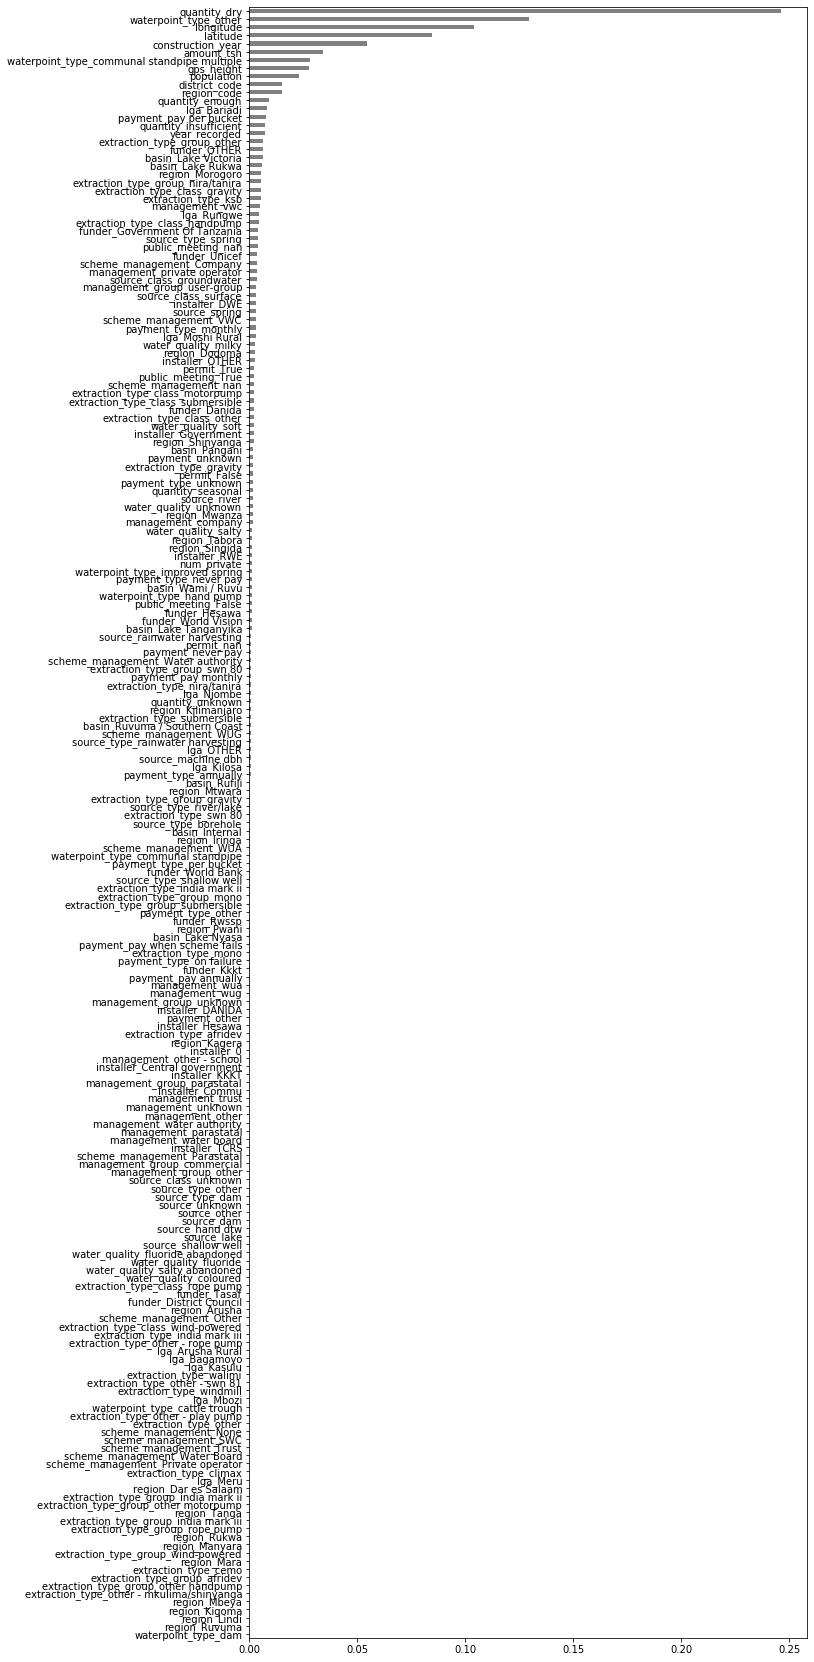

In [100]:
# Visualize feature importances
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [0]:
# Generate test prediction

y_pred = pipeline.predict(X_test)

# Generate Kaggle submission csv

#sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('lori_monday.csv', index=False)

from google.colab import files
files.download('lori_monday.csv')

In [104]:
submission.shape

(14358, 2)